# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
plt.rcParams["figure.figsize"] = (12,5)


# Upload & load train.csv

In [3]:
df=pd.read_csv("/content/train.csv")
df


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


# Quick validation & basic cleaning

In [4]:
print("Columns:", df.columns.tolist())
print("Rows:", len(df))
print("Date range:", df['Date'].min(), "to", df['Date'].max())
print("Nulls per column:\n", df.isnull().sum())
df['Store'] = df['Store'].astype(int)
df['Dept'] = df['Dept'].astype(int)
df['Weekly_Sales'] = df['Weekly_Sales'].fillna(0)
df = df.sort_values('Date').reset_index(drop=True)


Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
Rows: 421570
Date range: 2010-02-05 to 2012-10-26
Nulls per column:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


# Aggregate to monthly totals (overall)

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
monthly_total = (
    df.set_index('Date')
      .resample('ME')['Weekly_Sales']
      .sum()
      .rename('Monthly_Sales')
)
print(monthly_total.head())


Date
2010-02-28    1.903330e+08
2010-03-31    1.819198e+08
2010-04-30    2.314124e+08
2010-05-31    1.867109e+08
2010-06-30    1.922462e+08
Freq: ME, Name: Monthly_Sales, dtype: float64


# Plot trend + moving averages

/tmp/ipython-input-2591513685.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


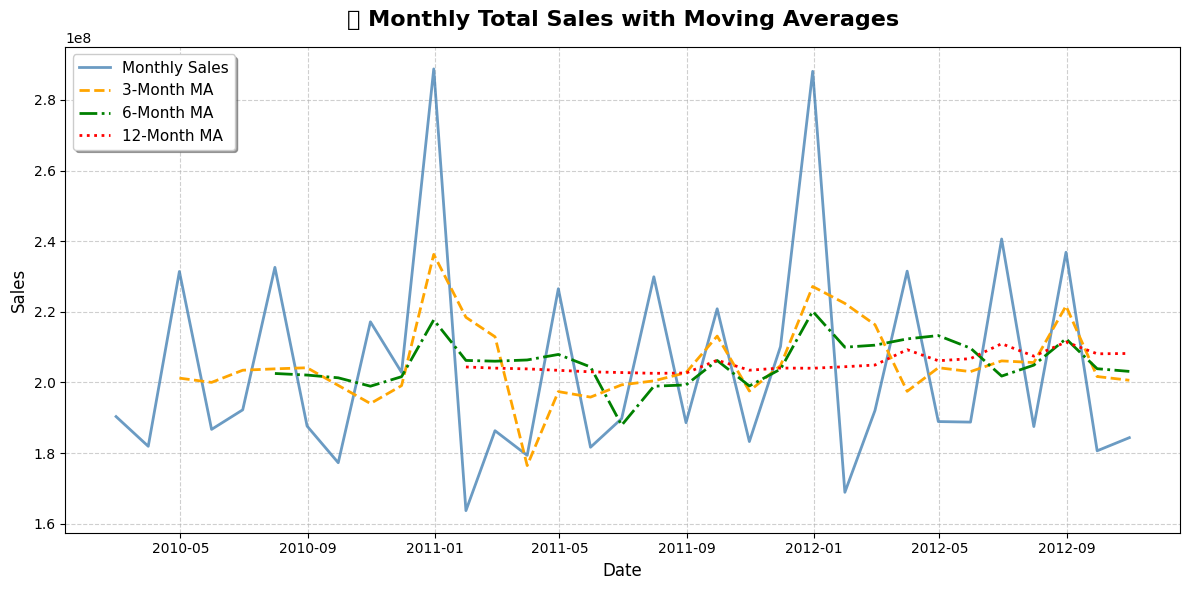

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(monthly_total, label='Monthly Sales', color='steelblue', linewidth=2, alpha=0.8)
plt.plot(monthly_total.rolling(window=3).mean(), label='3-Month MA', color='orange', linewidth=2, linestyle='--')
plt.plot(monthly_total.rolling(window=6).mean(), label='6-Month MA', color='green', linewidth=2, linestyle='-.')
plt.plot(monthly_total.rolling(window=12).mean(), label='12-Month MA', color='red', linewidth=2, linestyle=':')
plt.title('📊 Monthly Total Sales with Moving Averages', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, frameon=True, shadow=True, loc='upper left')
plt.tight_layout()
plt.show()


# Perform decomposition

In [17]:
if len(monthly_total.dropna()) >= 2 * period:
    decomposition = seasonal_decompose(monthly_total.dropna(), model='additive', period=period)
    print("✅ Decomposition successful!")
else:
    print("❌ Not enough monthly data for a robust 12-month decomposition. Need >= 24 months.")



✅ Decomposition successful!


# Observed

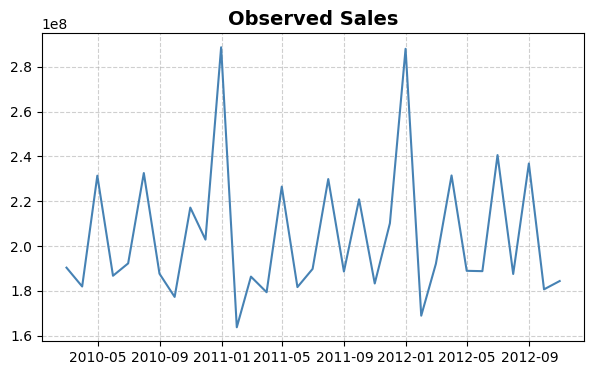

In [23]:
plt.figure(figsize=(7,4))
plt.plot(decomposition.observed, color='steelblue')
plt.title("Observed Sales", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



# Trend

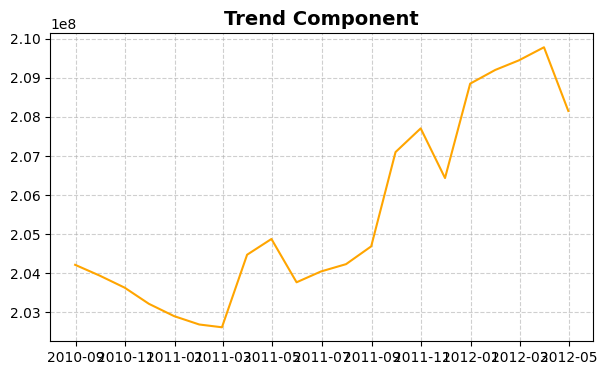

In [22]:
plt.figure(figsize=(7,4))
plt.plot(decomposition.trend, color='orange')
plt.title("Trend Component", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


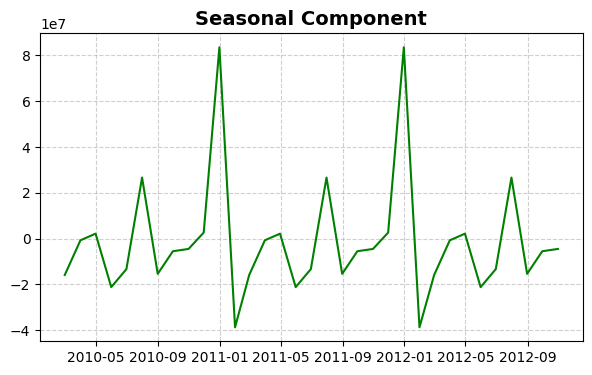

In [21]:
plt.figure(figsize=(7,4))
plt.plot(decomposition.seasonal, color='green')
plt.title("Seasonal Component", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Plot stacked area for top depts

/tmp/ipython-input-3085538175.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(key='Date', freq='M'), 'Dept'])['Weekly_Sales']


Top Depts: [92, 95, 38, 72, 90, 40]


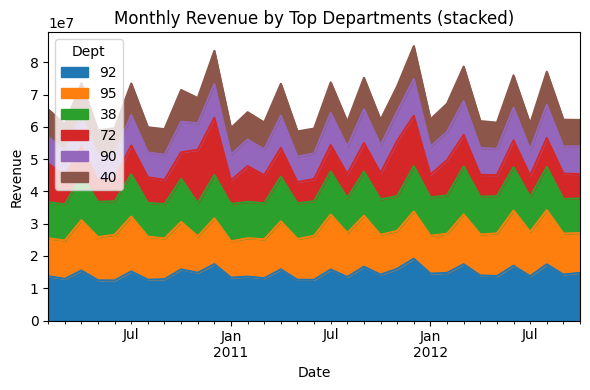

In [30]:
monthly_by_dept = (df
                  .groupby([pd.Grouper(key='Date', freq='M'), 'Dept'])['Weekly_Sales']
                  .sum()
                  .unstack(fill_value=0))
top_depts = monthly_by_dept.sum().sort_values(ascending=False).head(6).index.tolist()
print("Top Depts:", top_depts)
monthly_by_dept[top_depts].plot.area(figsize=(6,4))
plt.title('Monthly Revenue by Top Departments (stacked)')
plt.ylabel('Revenue'); plt.xlabel('Date'); plt.tight_layout()
plt.show()

# show trends for top departments individually

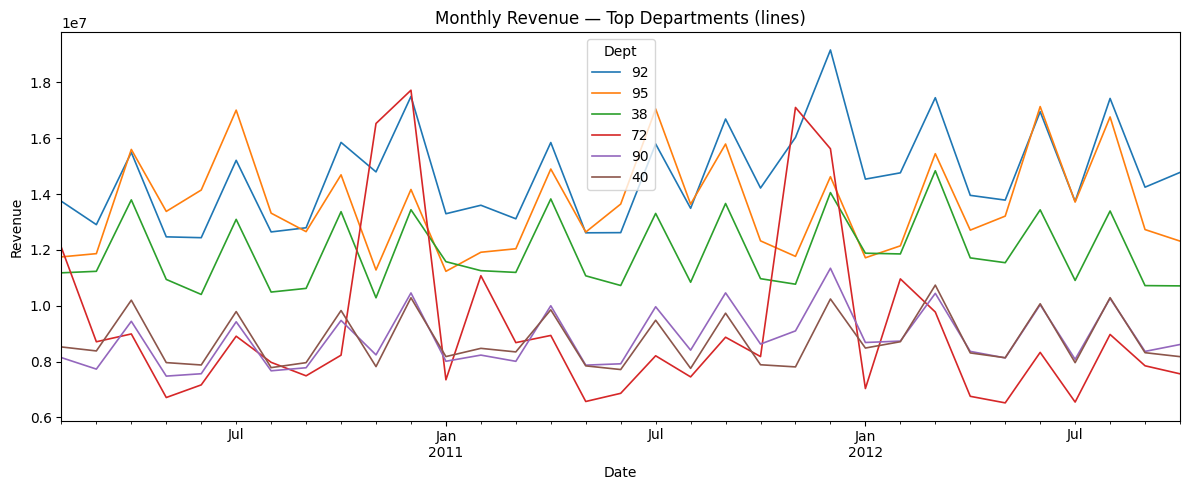

In [28]:
monthly_by_dept[top_depts].plot(subplots=False, linewidth=1.2)
plt.title('Monthly Revenue — Top Departments (lines)')
plt.ylabel('Revenue'); plt.tight_layout(); plt.show()

# Breakdown by Store (region)

/tmp/ipython-input-3659046403.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(key='Date', freq='M'), 'Store'])['Weekly_Sales']


Top Stores: [20, 4, 14, 13, 2, 10]


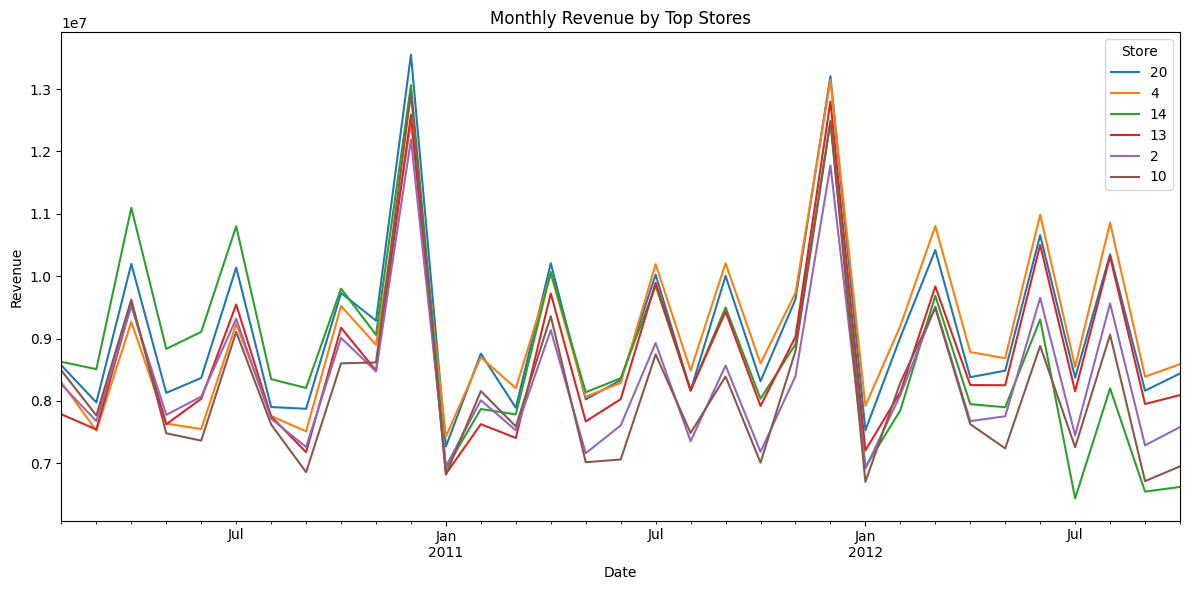

In [35]:
monthly_by_store = (df
                   .groupby([pd.Grouper(key='Date', freq='M'), 'Store'])['Weekly_Sales']
                   .sum()
                   .unstack(fill_value=0))
top_stores = monthly_by_store.sum().sort_values(ascending=False).head(6).index.tolist()
print("Top Stores:", top_stores)
monthly_by_store[top_stores].plot(figsize=(12,6))
plt.title('Monthly Revenue by Top Stores')
plt.ylabel('Revenue'); plt.xlabel('Date'); plt.tight_layout()
plt.show()


# Forecasting: prepare train/test split

In [36]:
if len(monthly_total) >= 36:
    test_periods = 12
elif len(monthly_total) >= 18:
    test_periods = 6
else:
    test_periods = max(1, int(len(monthly_total) * 0.2))

train = monthly_total[:-test_periods]
test = monthly_total[-test_periods:]

print("Monthly series length:", len(monthly_total))
print("Train length:", len(train), "Test length:", len(test))


Monthly series length: 33
Train length: 27 Test length: 6


# Baseline forecast: Rolling mean (naive)

/tmp/ipython-input-250034611.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=test.index[0], periods=h, freq='M')


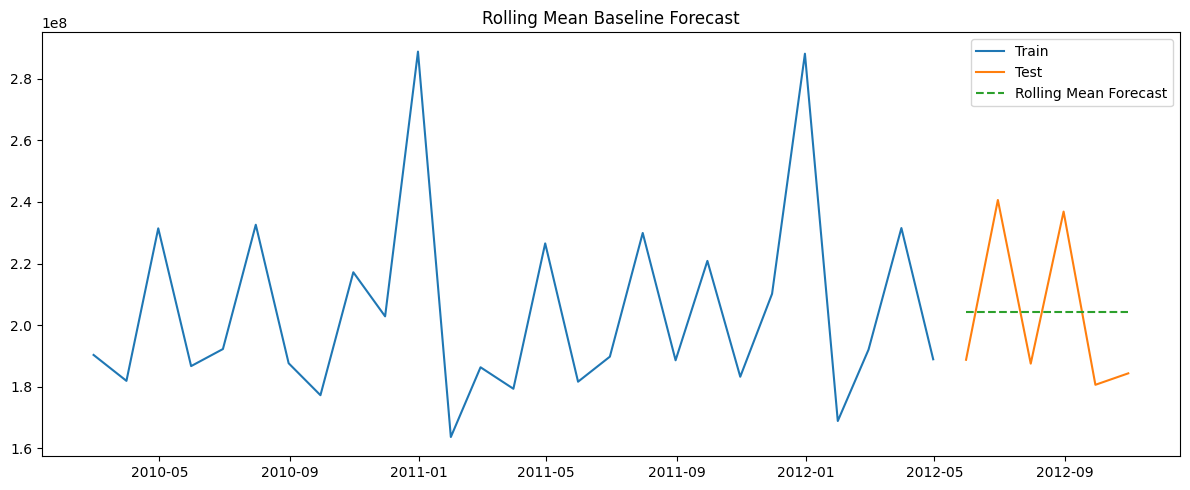

In [37]:
last_rolling_mean = train.rolling(window=3).mean().iloc[-1]
h = len(test)
forecast_index = pd.date_range(start=test.index[0], periods=h, freq='M')

rolling_forecast = pd.Series([last_rolling_mean]*h, index=forecast_index).rename('RollingForecast')
plt.figure()
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(rolling_forecast, label='Rolling Mean Forecast', linestyle='--')
plt.title('Rolling Mean Baseline Forecast')
plt.legend(); plt.tight_layout(); plt.show()


# Holt-Winters Exponential Smoothing forecast

Using seasonal_periods = 12


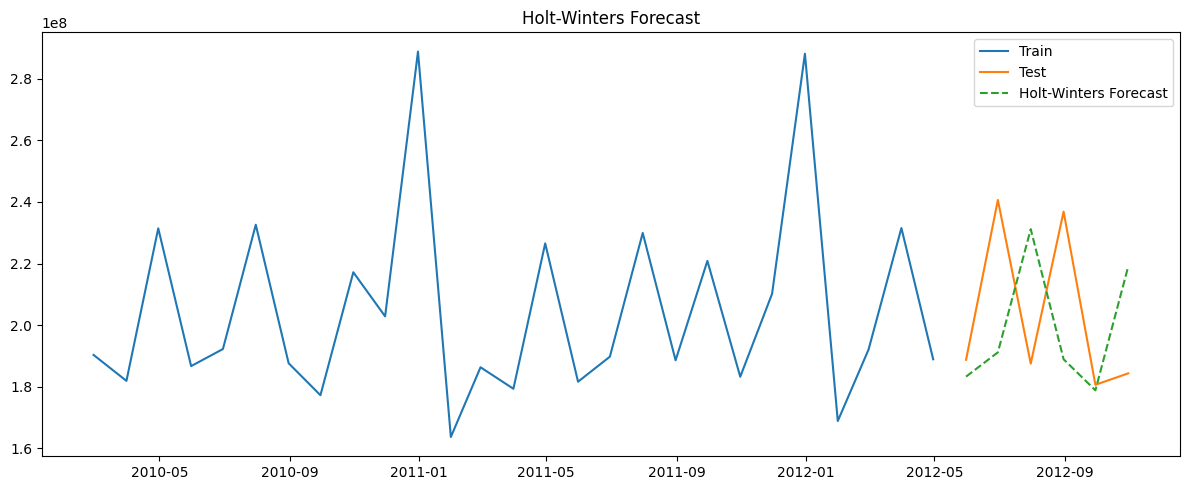

In [38]:
seasonal_periods = 12 if len(train) >= 24 else max(2, int(len(train)/4))
print("Using seasonal_periods =", seasonal_periods)

try:
    hw_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods).fit()
    hw_forecast = hw_model.forecast(h).rename('HWForecast')
    # Plot
    plt.figure()
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(hw_forecast, label='Holt-Winters Forecast', linestyle='--')
    plt.title('Holt-Winters Forecast')
    plt.legend(); plt.tight_layout(); plt.show()
except Exception as e:
    print("Holt-Winters failed:", e)
    hw_forecast = None


# Evaluate forecasts (MAE, RMSE)

In [39]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

results = {}
mae_rolling, rmse_rolling = evaluate(test.values, rolling_forecast.values)
results['RollingMean'] = {'MAE': mae_rolling, 'RMSE': rmse_rolling}
if hw_forecast is not None:
    mae_hw, rmse_hw = evaluate(test.values, hw_forecast.values)
    results['HoltWinters'] = {'MAE': mae_hw, 'RMSE': rmse_hw}

import pprint
pprint.pprint(results)


{'HoltWinters': {'MAE': 30498311.407346193, 'RMSE': 36250356.98079927},
 'RollingMean': {'MAE': 24084560.36944445, 'RMSE': 25352434.67535117}}


# Save summaries and forecasts

In [40]:
monthly_total.to_csv('monthly_total_sales.csv')
monthly_by_dept.to_csv('monthly_by_dept.csv')
monthly_by_store.to_csv('monthly_by_store.csv')
rolling_forecast.to_csv('rolling_forecast.csv')
if hw_forecast is not None:
    hw_forecast.to_csv('hw_forecast.csv')
from google.colab import files
files.download('monthly_total_sales.csv')
files.download('monthly_by_dept.csv')
files.download('monthly_by_store.csv')
files.download('rolling_forecast.csv')
if hw_forecast is not None:
    files.download('hw_forecast.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Short automatic interpretation (copy into your report)

In [41]:
# Step 14: Auto-generate short interpretation bullets
print("\n--- Quick Findings Template ---")
print("1) Overall trend: describe whether monthly_total shows upward/downward/flat trend.")
print("2) Seasonality: months with consistent peaks (see seasonal plot).")
print("3) Top products (Depts):", top_depts)
print("4) Top stores:", top_stores)
print("5) Forecast performance: Rolling MAE = {:.2f}, RMSE = {:.2f}".format(results['RollingMean']['MAE'], results['RollingMean']['RMSE']))
if 'HoltWinters' in results:
    print("   Holt-Winters MAE = {:.2f}, RMSE = {:.2f}".format(results['HoltWinters']['MAE'], results['HoltWinters']['RMSE']))
print("6) Recommendation: analyze holiday spikes (IsHoliday), promotions, and consider ARIMA/Prophet or ML models with `features.csv` for improved forecasting.")



--- Quick Findings Template ---
1) Overall trend: describe whether monthly_total shows upward/downward/flat trend.
2) Seasonality: months with consistent peaks (see seasonal plot).
3) Top products (Depts): [92, 95, 38, 72, 90, 40]
4) Top stores: [20, 4, 14, 13, 2, 10]
5) Forecast performance: Rolling MAE = 24084560.37, RMSE = 25352434.68
   Holt-Winters MAE = 30498311.41, RMSE = 36250356.98
6) Recommendation: analyze holiday spikes (IsHoliday), promotions, and consider ARIMA/Prophet or ML models with `features.csv` for improved forecasting.
